In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer

Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset_type = 'chirps'
input_size = 50
step = 5
dropout_rate = 0.2
learning_rate = 0.001
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [14]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, relu, batch, drop in zip(self.conv_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)
            x = batch(x)
            x = relu(x)
            x = drop(x)
            
        return x

In [15]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        for conv, relu, batch, drop in zip(self.conv_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = relu(x)
            x = drop(x)
            
        out = self.conv_final(x)
        return out

In [16]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [17]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [18]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_data.x.shape[1]).to(device)
criterion = RMSELoss()
opt_params = {'lr': 0.001, 
              'alpha': 0.9, 
              'eps': 1e-6}
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

Training the model

In [19]:
model_path = os.path.join('../../../models/STConvS2S' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, cut_output=False, recurrent_model=False, patience= 5)


In [25]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 6.468219
Val Avg. Loss: 6.439953
=> Saving a new best
Train - Epoch 1, Epoch Loss: 6.397050
Val Avg. Loss: 6.464166
Train - Epoch 2, Epoch Loss: 6.380307
Val Avg. Loss: 6.556258
Train - Epoch 3, Epoch Loss: 6.379058
Val Avg. Loss: 6.404494
=> Saving a new best
Train - Epoch 4, Epoch Loss: 6.367175
Val Avg. Loss: 6.413828
Train - Epoch 5, Epoch Loss: 6.368180
Val Avg. Loss: 6.376284
=> Saving a new best
Train - Epoch 6, Epoch Loss: 6.358552
Val Avg. Loss: 6.455235
Train - Epoch 7, Epoch Loss: 6.359000
Val Avg. Loss: 6.398074
Train - Epoch 8, Epoch Loss: 6.349649
Val Avg. Loss: 6.645990
Train - Epoch 9, Epoch Loss: 6.352081
Val Avg. Loss: 6.430235
Train - Epoch 10, Epoch Loss: 6.351630
Val Avg. Loss: 6.362059
=> Saving a new best
Train - Epoch 11, Epoch Loss: 6.354621
Val Avg. Loss: 6.417589
Train - Epoch 12, Epoch Loss: 6.343198
Val Avg. Loss: 6.397873
Train - Epoch 13, Epoch Loss: 6.340757
Val Avg. Loss: 6.396792
Train - Epoch 14, Epoch Loss: 6.340146
Val A

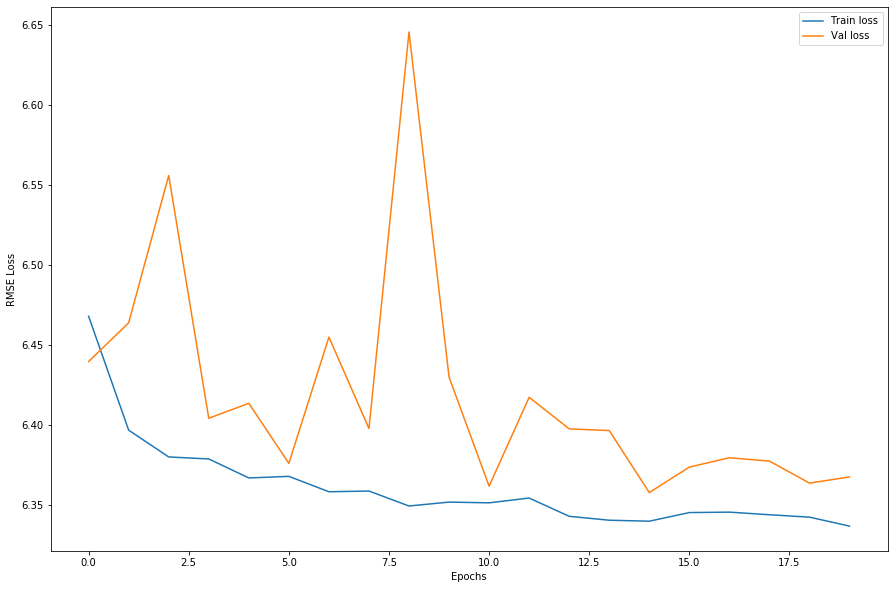

In [26]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [27]:
model, optimizer, epoch, loss = trainer.load_model()
iter_test_loss = 0.0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        iter_test_loss += loss.detach().item()
test_loss = iter_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 6.3311


In [22]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, time, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        for j in range(time):
            explained_variance += metrics.explained_variance_score(y_true[i,0,j,:,:], y_pred[i,0,j,:,:])
    return explained_variance / (batch*time)

def report_r2(y_true, y_pred):
    batch, ch, time, lat, lon = y_true.shape
    r2 = 0
    ar2 = 0
    for i in range(batch):
        for j in range(time):
            mse = metrics.mean_squared_error(y_true[i,0,j,:,:], y_pred[i,0,j,:,:]) 
            r2 += metrics.r2_score(y_true[i,0,j,:,:], y_pred[i,0,j,:,:])
            ar2 +=  1.0 - ( mse / y_true[i,0,j,:,:].var() )
    r2 = r2/(batch*time)
    ar2 = ar2/(batch*time)
    return r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('STConvS2S')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

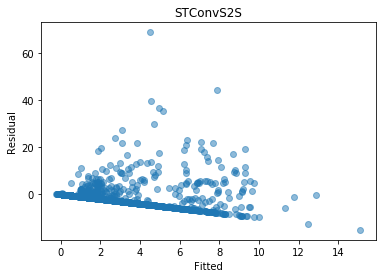

STConvS2S: 6.3311
Explained variance:  -2.1237293297859986e+18
r2:  -1.132317777728773e+19
ar2:  0.18


In [26]:
trainer.path = '../../../models/CHIRPS/5_step/STConvS2S_m04d08-h15m32s57.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        y_true = y.cpu().numpy()
        y_pred = output.cpu().numpy()
        if (i == 0):
            plot_residual_fitted(y_true[0,0,0,:,:], y_pred[0,0,0,:,:])
        batch_test_loss += loss.detach().item()
        batch_explained_variance += report_explained_variance(y_true, y_pred)
        r2, ar2 = report_r2(y_true, y_pred)
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss = batch_test_loss/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'STConvS2S: {test_loss:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))